In [6]:
import pandas as pd
import os
import sys
sys.path.append(os.path.pardir)
import core,model
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import pdb
import torch.tensor as tensor
from matplotlib import pyplot as plt
torch.cuda.set_device(1)

In [7]:
img_path_train = '/data/project/seq2seq_imgs/avt_code_imgs/20180001/'
img_seq_train = core.get_img_path_seq_from_path(img_path_train)
img_seq_train[:5]

[['/data/project/seq2seq_imgs/avt_code_imgs/20180001/3100173320_50_294_cde6b239ffa3842175b81c2d04b23a01.jpg',
  '3100173320'],
 ['/data/project/seq2seq_imgs/avt_code_imgs/20180001/3200164350_50_302_df9a27111ef14bd94a400e0f27dd6d3a.jpg',
  '3200164350'],
 ['/data/project/seq2seq_imgs/avt_code_imgs/20180001/3500171320_50_263_0aa3f89ccff95e60d87a61d51af0563e.jpg',
  '3500171320'],
 ['/data/project/seq2seq_imgs/avt_code_imgs/20180001/4500173320_50_274_fd36f8daf99930503aa8022f7f5aff1c.jpg',
  '4500173320'],
 ['/data/project/seq2seq_imgs/avt_code_imgs/20180001/4500171320_50_265_46fcd2b1c56503ced12943bc9f4d9763.jpg',
  '4500171320']]

In [36]:
import cv2
def shuffle(*args):
    if len(args) < 2:
        raise Exception('args should be greater than 2')
    item = np.stack(args, axis = 1)
    np.random.shuffle(item)
    return zip(*item)

def make_batches_img_seq(img_paths, labels, sz, bs = 32, is_shuffle = True, drop_last = False):
    if is_shuffle:
        img_paths,labels = shuffle(img_paths, labels)
        labels = np.array(labels).astype(int)
    
    last_batch = not drop_last and bool(len(labels)%bs)
    num_of_batches = int(len(labels)/bs)
    print(f'Making batches... batch size: {bs},num of batchese: {num_of_batches+1 if last_batch else num_of_batches}')
    start,end,= 0,bs

    for i in range(num_of_batches):
        paths = img_paths[start:end]
        imgs = []
        for path in paths:
            imgs += [cv2.resize(cv2.imread(path),(sz[0],sz[1]))]
        labels_local = labels[start:end]
        yield tensor(imgs,dtype=torch.float).permute(0,3,1,2),tensor(labels_local)
        start+=bs
        end+=bs
    
    if last_batch:
        paths = img_paths[start:]
        labels_local = img_paths[start:]
        imgs = []
        for path in paths:
            imgs += [cv2.imread(path)]
        labels_local = labels[start:end]
        yield tensor(imgs,dtype=torch.float).permute(0,3,1,2),tensor(labels_local)

In [37]:
img_paths_train, seq_train = zip(*img_seq_train)
dl = make_batches_img_seq(np.array(img_paths_train), np.array(seq_train).astype(int),sz = (285,50), bs=64)

In [38]:
a = next(iter(dl))

Making batches... batch size: 64,num of batchese: 522


In [40]:
a[0].shape

torch.Size([64, 3, 50, 285])

In [41]:
a[1][0]

tensor(4500173320)

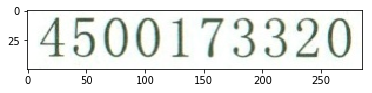

In [47]:
import matplotlib.pyplot as plt
img = a[0][0].permute(1,2,0).numpy().astype(int)
plt.imshow(img)